- 군집화
    - 이것도 논문을 찾든 뭘하든 있어보이는걸로 갈아끼우기
- 변수 중요도
- 위 근거를 통한 추천문구 생성형 ai

- 해야할거
    - 이 분석은 예금 deposit이 있다는 전제하에 보유한 고객을 segmentation한거임
        - 이건아님. 여튼 deposit데이터를 뺐는데..
        - 다른 자료 찾아보기, 엔투 찾아보기
        - 전처리 방법 통일 (새 노트 파기)
        - 은혜 데이터 변경
        - 논문을 하든 다른 기술로 변경
    - feature importance in segmentaiton (혹은 모델링을 별도 수행해야할듯)
    - 생성형 ai

In [26]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [43]:
data_path = '/content/drive/MyDrive/Colab Notebooks/KB_AI/data/'
df = pd.read_csv(data_path +'bank.csv')
print(len(df))
df.head()

11162


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [28]:
df = df.iloc[:,:6] # 여섯개의 칼럼만 선택
df.drop("default", axis=1,inplace=True) # 그러고 default도 버리고
df = df[df['balance'] > 0] # balance 0 초과만
df

,age,job,marital,education,balance
0,59,admin.,married,secondary,2343
1,56,admin.,married,secondary,45
2,41,technician,married,secondary,1270
3,55,services,married,secondary,2476
4,54,admin.,married,tertiary,184
...,...,...,...,...,...
11154,52,technician,married,tertiary,523
11155,35,blue-collar,married,secondary,80
11157,33,blue-collar,single,primary,1
11158,39,services,married,secondary,733


In [29]:
print(df.duplicated().sum(),'\n') # 중복된 데이터 있는지
print(df.isna().sum()) # 결측치 있는지

718 

age          0
job          0
marital      0
education    0
balance      0
dtype: int64


In [30]:
df = df.drop_duplicates() # 중복 데이터 삭제

In [31]:
# dtype과 type()의 차이는 이거다
print(type(df['job']))
print(df['job'].dtype)

<class 'pandas.core.series.Series'>
object


In [32]:
# 이거좀 습관으로..

continuous_feat = []
categorical_feat = []

for col in df.columns :
    if df[col].dtype == object :
        categorical_feat.append(col)
        print(df[col].value_counts(),'\n')
    else :
        continuous_feat.append(col)

print(continuous_feat,'\n')
print(categorical_feat)
print(df[categorical_feat].nunique())

management       2051
blue-collar      1561
technician       1474
admin.           1064
services          748
retired           626
self-employed     331
student           294
unemployed        285
entrepreneur      265
housemaid         224
unknown            59
Name: job, dtype: int64 

married     5073
single      2911
divorced     998
Name: marital, dtype: int64 

secondary    4404
tertiary     2944
primary      1220
unknown       414
Name: education, dtype: int64 

['age', 'balance'] 

['job', 'marital', 'education']
job          12
marital       3
education     4
dtype: int64


In [33]:
# 범주형 데이터 처리
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

onehot_cols = pd.DataFrame(encoder.fit_transform(df[categorical_feat]))
onehot_cols.index = df.index

df_continous = df.drop(categorical_feat, axis=1)

df_onehot = pd.concat([df_continous, onehot_cols], axis=1)
df_onehot

,age,balance,0,1,2,3,4,5,6,7,...,9,10,11,12,13,14,15,16,17,18
0,59,2343,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,56,45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,41,1270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,55,2476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,54,184,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11154,52,523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
11155,35,80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
11157,33,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
11158,39,733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


<Axes: xlabel='balance', ylabel='Density'>

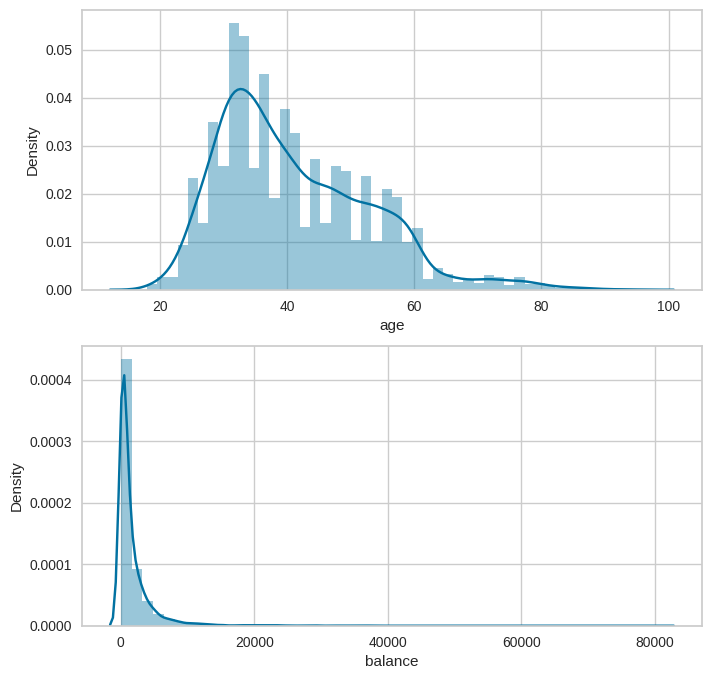

In [34]:
# 수치형 변수 정규화 전
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
sns.distplot(df_onehot['age'], ax=ax1)
sns.distplot(df_onehot['balance'], ax=ax2)

<Axes: xlabel='balance', ylabel='Density'>

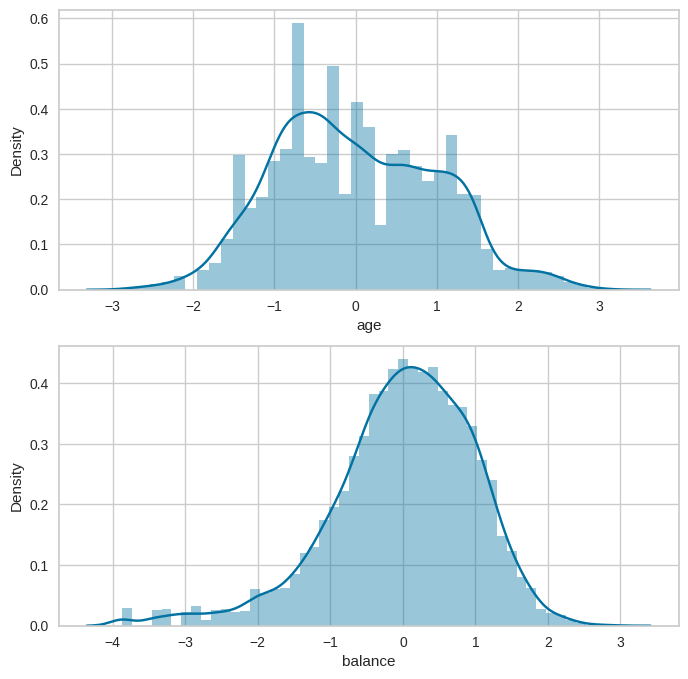

In [35]:
# 정규화 후
df_onehot[continuous_feat] = np.log(df_onehot[continuous_feat])
scaler = StandardScaler()
df_onehot[continuous_feat] = scaler.fit_transform(df_onehot[continuous_feat])
df[continuous_feat] = scaler.fit_transform(df[continuous_feat])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
sns.distplot(df_onehot['age'], ax=ax1)
sns.distplot(df_onehot['balance'], ax=ax2)

In [38]:
 df_onehot

,age,balance,0,1,2,3,4,5,6,7,...,9,10,11,12,13,14,15,16,17,18
0,1.436603,0.795320,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.249294,-1.581964,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.130231,0.426977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.184621,0.828528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.118761,-0.734945,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11154,0.983300,-0.106632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
11155,-0.437678,-1.235906,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
11157,-0.648873,-3.871519,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
11158,-0.049270,0.096399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


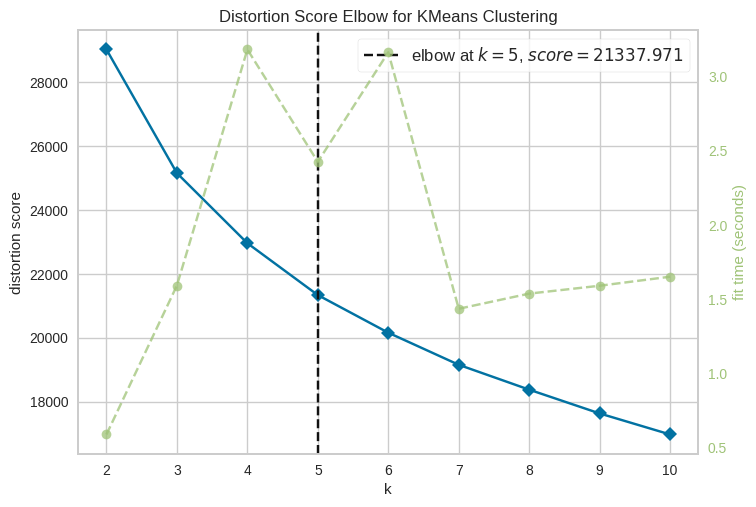

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
# 군집화 모델링 - 적정 k 찾기
df_onehot.columns = df_onehot.columns.astype(str)

Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df_onehot)
Elbow_M.show()

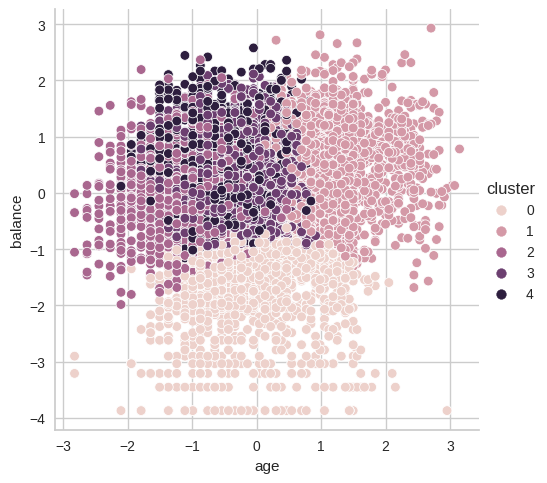

In [41]:
# 군집화 모델링 - 군집화 시작
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=30, max_iter=100, random_state=0)
clusters = kmeans.fit_predict(df_onehot)
df_onehot['cluster'] = clusters # 몇번째 군집인지 새 변수 생성 -> 여기의 cluster들의 결과값을 df 원본에 붙일거임.
sns.relplot(x='age', y='balance', hue='cluster', data=df_onehot)

(어쨌든 이렇게 기준으로는) 군집화가 매우 잘 형성됨. 비현실적으로..

In [42]:
df = pd.read_csv(data_path +'bank.csv')
df = df.iloc[:,:6]
df = df.drop(columns='default')
df = df[df['balance'] > 0]
df = df.drop_duplicates()
df['cluster'] = clusters # 위에서 구한 clsuters 결과값을 여기로 붙여준다

# cluster, job, marital, education을 기준으로 그룹을 생성
groups = df.groupby(['cluster', 'job', 'marital', 'education']).agg(['median', 'sum', 'count']).round()
groups['percentage'] = (groups['balance']['sum'] / groups['balance']['sum'].sum()).round(3)*100

top = groups.sort_values(by='percentage', ascending=False)
top.head(60) # 가장 높은 비율을 차지하는 대로 상위 60개

age               balance  \
                                         median    sum count   median   
cluster job           marital  education                                
4       management    single   tertiary    32.0  18396   555   1120.0   
                      married  tertiary    36.0  19069   518   1129.0   
1       management    married  tertiary    54.0  13201   243   1453.0   
3       blue-collar   married  secondary   37.0  17025   450    782.0   
1       retired       married  secondary   62.0  11747   183   1612.0   
3       technician    married  secondary   38.0  12543   329    880.0   
1       blue-collar   married  primary     50.0   9082   179   1080.0   
2       technician    single   secondary   31.0   9733   303    664.0   
3       admin.        married  secondary   38.0  10073   264    862.0   
4       technician    single   tertiary    32.0   4407   132   1690.0   
1       retired       married  primary     68.0  10169   150   1524.0   
3       services      married  secondary   37.0   8286   223    804.0   
1       technician    married  secondary   54.0   5906   108   1476.0   
2       admin.        single   secondary   31.0   7627   239    585.0   
        blue-collar   single   secondary   30.0   6398   212    570.0   
4       technician    married  tertiary    35.0   3315    93   1327.0   
3       blue-collar   married  primary     37.0   6066   165    714.0   
4       management    divorced tertiary    40.0   4579   115    859.0   
1       retired       married  tertiary    64.0   4494    69   2194.0   
2       student       single   secondary   25.0   3558   142    520.0   
1       admin.        married  secondary   55.0   4843    88   1564.0   
        blue-collar   married  secondary   53.0   4450    82   1308.0   
4       self-employed single   tertiary    32.0   2115    64   1706.0   
2       services      single   secondary   30.0   5328   175    489.0   
1       management    divorced tertiary    56.0   3013    54   2037.0   
        entrepreneur  married  tertiary    51.0   1317    25   1961.0   
        retired       divorced primary     74.0   3786    52    761.0   
        admin.        single   secondary   52.0   1521    29   2252.0   
        housemaid     married  primary     54.0   3144    58    868.0   
        management    married  secondary   54.0   2602    48   1587.0   
3       management    married  secondary   38.0   2063    56    739.0   
4       student       single   tertiary    28.0    738    25   3415.0   
1       retired       divorced secondary   60.0   2860    45   1099.0   
3       entrepreneur  married  secondary   38.0   1745    46    944.0   
1       management    married  primary     50.0   1726    34   1736.0   
3       technician    divorced secondary   39.0   2197    56    998.0   
1       technician    married  tertiary    52.0   2387    46   1181.0   
        services      married  secondary   52.0   2494    47   1134.0   
4       admin.        single   tertiary    34.0   1095    32   1054.0   
2       student       single   unknown     25.0   1286    50    792.0   
4       technician    single   unknown     41.0    205     5  11115.0   
1       unemployed    married  secondary   54.0   1754    32   1383.0   
        management    married  unknown     53.0   1790    33   2240.0   
4       self-employed married  tertiary    32.0   1243    37   1464.0   
        entrepreneur  married  tertiary    37.0   1139    31   1110.0   
1       self-employed married  secondary   53.0   1006    19   2061.0   
        services      married  primary     50.0   1258    25   1830.0   
4       unemployed    single   tertiary    35.0    871    25   1974.0   
1       unknown       married  unknown     52.0   1195    22   1544.0   
3       admin.        divorced secondary   40.0   2202    55    777.0   
1       self-employed divorced tertiary    61.0    180     3   6610.0   
        admin.        divorced secondary   53.0   1881    35   1693.0   
3       unemployed    married